In [1]:
import pandas as pd
import numpy as np
import os
import json
import shutil

caption_dir = '/kaggle/input/tagged-anime-illustrations/danbooru-metadata/danbooru-metadata'

id_to_tags = {}

for filename in os.listdir(caption_dir):
    f_path = os.path.join(caption_dir, filename)
    if os.path.isfile(f_path):
        with open(f_path, 'r') as f:
            for line in f:
                data = json.loads(line.rstrip())
                tags = [x["name"] for x in data["tags"]]
                caption = " ".join(tags)
                id_to_tags[data["id"]] = caption 

In [2]:
from collections import Counter

tag_counter = Counter()
for tags in id_to_tags.values():
    for tag in tags.split(" "):
        tag = tag.strip()
        if tag:  # avoid empty strings
            tag_counter[tag] += 1
            
top_tags = [tag for tag, _ in tag_counter.most_common(500)]

top_tags_set = set(top_tags)

top_2000_id_to_tags = {
    img_id: " ".join([t for t in tags.split(" ") if t in top_tags_set])
    for img_id, tags in id_to_tags.items()
}

In [3]:
from collections import Counter

filtered_tag_counter_2000 = Counter()

for tags in top_2000_id_to_tags.values():
    for tag in tags.split(" "):
        tag = tag.strip()
        if tag:  
            filtered_tag_counter_2000[tag] += 1

print("Total unique tags:", len(filtered_tag_counter_2000))

Total unique tags: 500


In [4]:
print(top_2000_id_to_tags["1017000"])

1girl bow brown_hair detached_sleeves frills hair_bow hair_ribbon hair_tubes hakurei_reimu highres midriff navel red_eyes ribbon skirt skirt_set solo standing touhou


In [5]:
unique_tags = list(filtered_tag_counter_2000.keys())

In [6]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DanbooruMultiLabelDataset(Dataset):
    def __init__(self, root_dir, label_dict, unique_tags, transform=None):
        """
        root_dir: folder with all subfolders of images
        label_dict: dict mapping 'image_id' -> list of tags
        unique_tags: list of all unique tags (defines the multi-label space)
        """
        self.root_dir = root_dir
        self.label_dict = label_dict
        self.tag_to_idx = {tag: i for i, tag in enumerate(unique_tags)}
        self.transform = transform

        # Collect image paths
        self.image_paths = []
        for subdir, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith((".jpg", ".jpeg", ".png")):
                    img_id = os.path.splitext(f)[0]
                    if img_id in label_dict:
                        self.image_paths.append(os.path.join(subdir, f))

    def __len__(self):
        return len(self.image_paths)

    def encode_tags(self, tags):
        vec = torch.zeros(len(self.tag_to_idx), dtype=torch.float32)
        for tag in tags:
            if tag in self.tag_to_idx:
                vec[self.tag_to_idx[tag]] = 1.0
        return vec

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
    
        img_id = os.path.splitext(os.path.basename(path))[0]
        tags_str = self.label_dict[img_id]
    
        # Split tags if they are stored as a space-separated string
        if isinstance(tags_str, str):
            tags = tags_str.split()  # split by whitespace
        else:
            tags = tags_str  # already a list
    
        label_vec = self.encode_tags(tags)
    
        if self.transform:
            img = self.transform(img)
    
        return img, label_vec

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dataset = DanbooruMultiLabelDataset(
    root_dir="/kaggle/input/tagged-anime-illustrations/danbooru-images/danbooru-images",
    label_dict=top_2000_id_to_tags,
    unique_tags=unique_tags,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

for images, label_vecs in dataloader:
    print(images.shape)      # (B, 3, 224, 224)
    print(label_vecs.shape)  # (B, num_tags)
    break

torch.Size([64, 3, 224, 224])
torch.Size([64, 500])


In [8]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducible splits
)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 269626 | Val: 33703 | Test: 33704


In [9]:
# Get one batch from the dataloader
imgs, labels = next(iter(train_loader))

# Print 5 label vectors and how many active tags they have
for i in range(5):
    label_vec = labels[i]
    print(f"\nSample {i} — Active tags: {int(label_vec.sum().item())}")
    print(label_vec.nonzero(as_tuple=True)[0].tolist())


Sample 0 — Active tags: 23
[6, 17, 18, 19, 25, 29, 46, 58, 59, 60, 63, 100, 162, 185, 207, 213, 234, 240, 248, 296, 299, 363, 495]

Sample 1 — Active tags: 13
[2, 3, 14, 25, 39, 46, 58, 59, 75, 156, 212, 241, 271]

Sample 2 — Active tags: 26
[3, 8, 11, 17, 18, 35, 45, 49, 58, 59, 61, 101, 103, 127, 128, 162, 189, 201, 252, 255, 273, 281, 296, 385, 462, 495]

Sample 3 — Active tags: 23
[2, 3, 6, 14, 17, 27, 29, 31, 58, 59, 92, 96, 107, 169, 205, 220, 222, 273, 278, 281, 309, 320, 399]

Sample 4 — Active tags: 31
[3, 4, 6, 8, 13, 14, 15, 17, 40, 54, 59, 61, 75, 96, 101, 104, 107, 112, 135, 144, 156, 157, 167, 224, 227, 314, 336, 346, 392, 406, 492]


In [10]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

n = len(dataset)
half = n // 2

# ✅ Split into ordered halves first
first_half_idx = list(range(0, half))
second_half_idx = list(range(half, n))

first_half = Subset(dataset, first_half_idx)
second_half = Subset(dataset, second_half_idx)

print(f"First half: {len(first_half)} samples")
print(f"Second half: {len(second_half)} samples")

First half: 168516 samples
Second half: 168517 samples


In [11]:
def split_80_10_10(subset, seed):
    n = len(subset)
    indices = list(range(n))
    train_idx, temp_idx = train_test_split(
        indices, test_size=0.2, random_state=seed, shuffle=False
    )
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.5, random_state=seed, shuffle=False
    )
    return (
        Subset(subset, train_idx),
        Subset(subset, val_idx),
        Subset(subset, test_idx),
    )

first_train, first_val, first_test = split_80_10_10(first_half, seed=RANDOM_SEED)
second_train, second_val, second_test = split_80_10_10(second_half, seed=RANDOM_SEED + 1)

In [12]:
def make_loader(subset, batch_size=64, shuffle=False):
    return DataLoader(
        subset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True
    )

train_loader_1 = make_loader(first_train)
val_loader_1   = make_loader(first_val, shuffle=False)
test_loader_1  = make_loader(first_test, shuffle=False)

train_loader_2 = make_loader(second_train)
val_loader_2   = make_loader(second_val, shuffle=False)
test_loader_2  = make_loader(second_test, shuffle=False)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
import numpy as np

# ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ======================
num_classes = 500
pretrained_weights = "/kaggle/input/model-resnet152-finetuned-first-half/model_resnet152_finetuned_first_half.pth"

model = models.resnet152(pretrained=False)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Load pretrained weights
state_dict = torch.load(pretrained_weights, map_location=device)
for k in ["fc.weight", "fc.bias"]:
    state_dict.pop(k, None)
missing, unexpected = model.load_state_dict(state_dict, strict=False)
print(f"Loaded pretrained weights (missing={len(missing)}, unexpected={len(unexpected)})")

model = model.to(device)

# ======================
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# ======================
def find_best_thresholds(y_true, y_pred_proba):
    thresholds = []
    for i in range(y_true.shape[1]):
        p, r, t = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
        f1 = 2 * p * r / (p + r + 1e-8)
        if len(f1) > 0 and not np.all(np.isnan(f1)):
            thresholds.append(t[np.nanargmax(f1)])
        else:
            thresholds.append(0.2)
    return np.clip(np.array(thresholds, dtype=np.float32), 0.05, 0.95)

# ======================
num_epochs = 10
history = {"train_loss": [], "val_loss": [], "f1": [], "precision": [], "recall": []}

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0.0
    for imgs, labels in tqdm(train_loader_2, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader_2.dataset)

    # ---- Validation ----
    model.eval()
    all_probs, all_labels = [], []
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader_2, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item() * imgs.size(0)
            probs = torch.sigmoid(outputs).cpu()
            all_probs.append(probs)
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    val_loss /= len(val_loader_2.dataset)

    # Fixed threshold (for validation tracking)
    preds = (all_probs > 0.2).astype(int)
    f1 = f1_score(all_labels, preds, average="samples", zero_division=0)
    precision = precision_score(all_labels, preds, average="samples", zero_division=0)
    recall = recall_score(all_labels, preds, average="samples", zero_division=0)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f}")

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

# ======================
# Compute best thresholds ONCE after final epoch
best_thresholds = find_best_thresholds(all_labels, all_probs)
np.save("best_thresholds.npy", best_thresholds)
print(" Best thresholds saved to best_thresholds.npy")

# ======================
# Test evaluation
model.eval()
all_probs, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader_2, desc="Testing"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.sigmoid(outputs).cpu()
        all_probs.append(probs)
        all_labels.append(labels.cpu())

all_probs = torch.cat(all_probs).numpy()
all_labels = torch.cat(all_labels).numpy()

preds = (all_probs > best_thresholds).astype(int)
precision = precision_score(all_labels, preds, average="samples", zero_division=0)
recall = recall_score(all_labels, preds, average="samples", zero_division=0)
f1 = f1_score(all_labels, preds, average="samples", zero_division=0)

print(f"\n Test Results (Tuned Thresholds)")
print(f"F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# ======================
torch.save(model.state_dict(), "model_resnet152_finetuned_second_half.pth")
print("Model saved successfully!")


Device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights (missing=2, unexpected=0)


Epoch 1/10 [Train]:  92%|█████████▏| 1938/2107 [54:04<04:43,  1.68s/it]/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:760: UserWarning: Metadata Warning, tag 296 had too many entries: 2, expected 1
  warnings.warn(
Epoch 1/10 [Val]: 100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


Epoch [1/10] | Train Loss: 0.1062 | Val Loss: 0.1012 | P: 0.4302 | R: 0.4145 | F1: 0.4016


Epoch 2/10 [Val]: 100%|██████████| 264/264 [02:18<00:00,  1.90it/s]


Epoch [2/10] | Train Loss: 0.0972 | Val Loss: 0.1005 | P: 0.4308 | R: 0.4233 | F1: 0.4061


Epoch 3/10 [Val]: 100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


Epoch [3/10] | Train Loss: 0.0916 | Val Loss: 0.1020 | P: 0.4296 | R: 0.4213 | F1: 0.4032


Epoch 4/10 [Val]: 100%|██████████| 264/264 [02:18<00:00,  1.90it/s]


Epoch [4/10] | Train Loss: 0.0859 | Val Loss: 0.1053 | P: 0.4116 | R: 0.4220 | F1: 0.3943


Epoch 5/10 [Val]: 100%|██████████| 264/264 [02:18<00:00,  1.90it/s]


Epoch [5/10] | Train Loss: 0.0813 | Val Loss: 0.1066 | P: 0.4160 | R: 0.4187 | F1: 0.3946


Epoch 6/10 [Val]: 100%|██████████| 264/264 [02:18<00:00,  1.90it/s]


Epoch [6/10] | Train Loss: 0.0771 | Val Loss: 0.1084 | P: 0.3995 | R: 0.4250 | F1: 0.3884


Epoch 7/10 [Val]: 100%|██████████| 264/264 [02:19<00:00,  1.90it/s]


Epoch [7/10] | Train Loss: 0.0732 | Val Loss: 0.1119 | P: 0.4002 | R: 0.4147 | F1: 0.3844


Epoch 8/10 [Val]: 100%|██████████| 264/264 [02:19<00:00,  1.90it/s]


Epoch [8/10] | Train Loss: 0.0698 | Val Loss: 0.1126 | P: 0.3773 | R: 0.4372 | F1: 0.3827


Epoch 9/10 [Val]: 100%|██████████| 264/264 [02:19<00:00,  1.89it/s]


Epoch [9/10] | Train Loss: 0.0664 | Val Loss: 0.1152 | P: 0.3793 | R: 0.4297 | F1: 0.3812


Epoch 10/10 [Val]: 100%|██████████| 264/264 [02:18<00:00,  1.90it/s]


Epoch [10/10] | Train Loss: 0.0631 | Val Loss: 0.1209 | P: 0.3760 | R: 0.4125 | F1: 0.3713


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class f

 Best thresholds saved to best_thresholds.npy


Testing: 100%|██████████| 264/264 [02:20<00:00,  1.88it/s]



 Test Results (Tuned Thresholds)
F1: 0.3419 | Precision: 0.2950 | Recall: 0.4734
Model saved successfully!


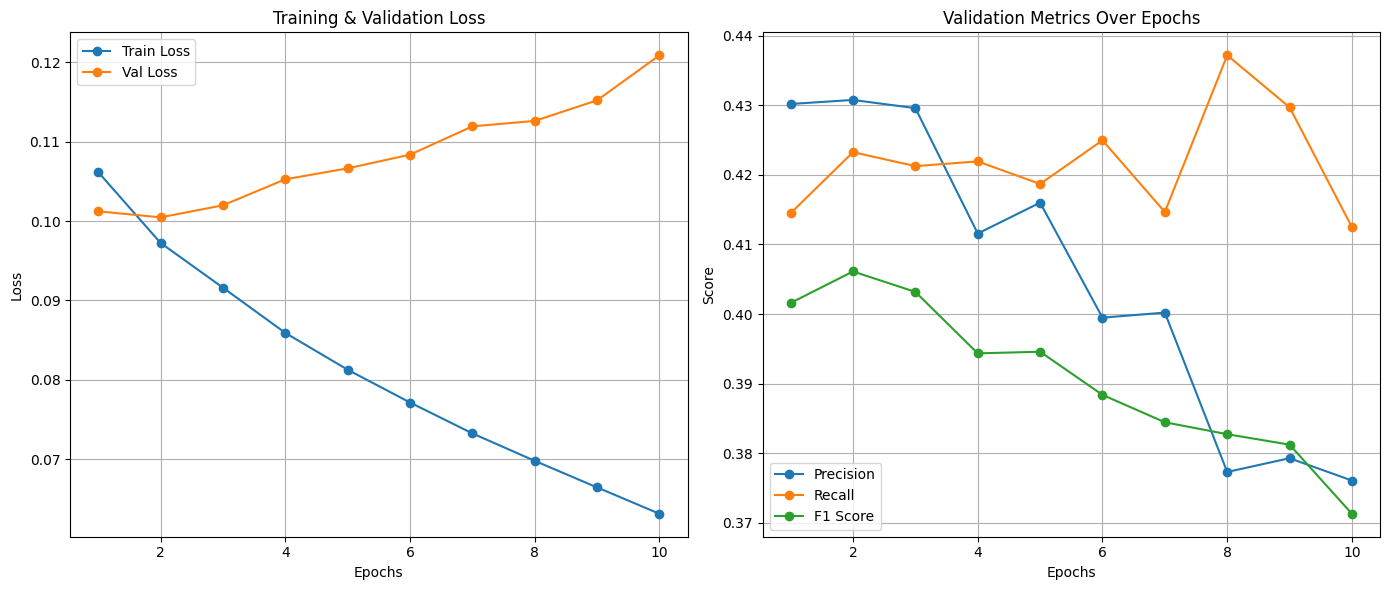

In [14]:
import matplotlib.pyplot as plt

# Visualize your logged training history
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# ---- Loss curves ----
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, history["val_loss"], label="Val Loss", marker='o')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# ---- Metrics curves ----
plt.subplot(1, 2, 2)
plt.plot(epochs, history["precision"], label="Precision", marker='o')
plt.plot(epochs, history["recall"], label="Recall", marker='o')
plt.plot(epochs, history["f1"], label="F1 Score", marker='o')
plt.title("Validation Metrics Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
